<a href="https://colab.research.google.com/github/theSparta/NN_convergence/blob/master/2b_gam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License")

---


In [0]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
#@title Imports

from __future__ import division
from __future__ import print_function
import os.path as osp
import json
import re
from IPython.display import display
from copy import copy
from collections import Counter
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
#@title Enable tf v2 behavior
# Call this once
tf.enable_v2_behavior()

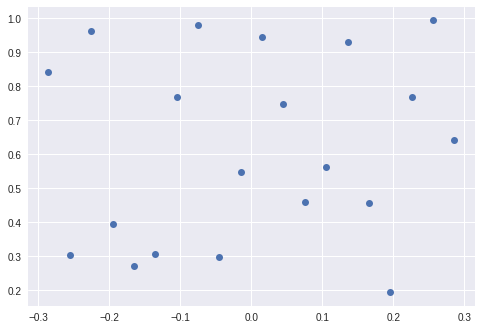

In [0]:
#@title Training Data Generation, Input Normalization and visualization

## Data Generation
num_data = 20
num_feature = 1
x = np.random.randn(num_data,num_feature)
for i in range(num_data):
    x[i,0] = i - num_data/2
x.sort(axis=0)
y = np.random.rand(num_data)

## Input Normalization
data_mean = np.mean(x)
data_var = np.mean(np.square(x - data_mean))
data_points = (x - data_mean)/(data_var + 1e-8)

data_targets = y
NUM_DATAPOINTS = len(x)

plt.plot(data_points, data_targets, 'o', label='original data')
plt.show()

In [0]:
#@title Model Definitions

class RBFLayer(tf.keras.layers.Layer):
  
  def __init__(self, num_units, activation='tanh'):
    super(RBFLayer, self).__init__()
    self.num_units = num_units
    self._activation = activation

  def build(self, input_shape):
    self.beta = self.add_weight(
        name='beta',
        shape=[input_shape[-1], self.num_units],
        initializer=tf.initializers.constant(5.0),
        trainable=True)
    self.c = self.add_weight(
        name='c',
        shape=[1, self.num_units],
        initializer=tf.initializers.random_uniform(-1.0, 1.0),
        trainable=True)
    self.sgn = 2 * np.random.randint(2, size = self.num_units) - 1
    self.sgn = tf.convert_to_tensor(self.sgn, dtype=tf.float64)
    
  def call(self, x):
    center = tf.tile(self.c, [tf.shape(x)[0], 1])
    distances = tf.square(x - center)
    if self._activation == 'tanh':
      out = tf.exp(self.beta) * (x - center)
      out = tf.tanh(self.sgn * out)
    elif self._activation == 'rbf':
      out = tf.exp(-tf.exp(self.beta) * distances)
    return out 

class SimpleNN(tf.keras.Model):
  def __init__(self, num_units, activation):
    super(SimpleNN, self).__init__()
    self.simple_dense = RBFLayer(num_units, activation=activation)
    self.linear = tf.keras.layers.Dense(
        1, use_bias=False,
        kernel_initializer=tf.initializers.ones()) #random_uniform(-1, 1))
    
  def call(self, x):
    x = self.simple_dense(x)
    x = tf.squeeze(self.linear(x), axis=-1)
    return x
  
class ComplexNN(tf.keras.Model):
  def __init__(self, num_inputs, num_units, activation='tanh'):
    super(ComplexNN, self).__init__()
    self.num_inputs = num_inputs
    self.simple_nns = [SimpleNN(num_units, activation) 
                       for _ in range(num_inputs)]
    
  def call(self, x):
    list_x = tf.split(x, self.num_inputs, axis=-1)
    out = tf.zeros(x.shape[0], dtype=x.dtype)
    for i, x_i in enumerate(list_x):
      out += self.simple_nns[i](x_i)
    return out

In [0]:
#@title Training helpers

def loss(model, inputs, targets):
  predicted_y = model(inputs)
  output = tf.sigmoid(predicted_y)
  logits = tf.stack([predicted_y, tf.zeros_like(predicted_y)], axis=1)
  labels = tf.stack([targets, 1 - targets], axis=1)
  loss_vals = tf.nn.softmax_cross_entropy_with_logits_v2(
      labels=labels, logits=logits)
  return tf.reduce_mean(loss_vals)

def mse_loss(model, inputs, targets):
  predicted = model(inputs)
  return tf.losses.mean_squared_error(predicted, targets)
  

def grad(model, inputs, targets, loss_fn=loss):
  with tf.GradientTape() as tape:
    loss_value = loss_fn(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

def plot_fig():
  plt.figure(figsize = (10, 10))
  plt.subplot(2,1,1)
  plt.title('label vs. prediction')
  plt.plot(data_points, data_targets,'o',label = 'original data')
  predicted = nn_model(data_points).numpy()
  plt.plot(data_points,predicted, label = 'NN prediction')
  plt.legend()
  plt.show()

In [0]:
#@title Dataset Preprocessing
assert data_points.shape[0] == data_targets.shape[0]
dataset = tf.data.Dataset.from_tensor_slices((data_points, data_targets))

BATCH_SIZE = 256 #@param {type: "integer"}
BATCH_SIZE = min(BATCH_SIZE, NUM_DATAPOINTS)
# ds_tensors = dataset.map(lambda x, y : (x/100, y))
ds_tensors = dataset 
ds_tensors = ds_tensors.apply(tf.data.experimental.shuffle_and_repeat(
    buffer_size=NUM_DATAPOINTS)).batch(BATCH_SIZE)

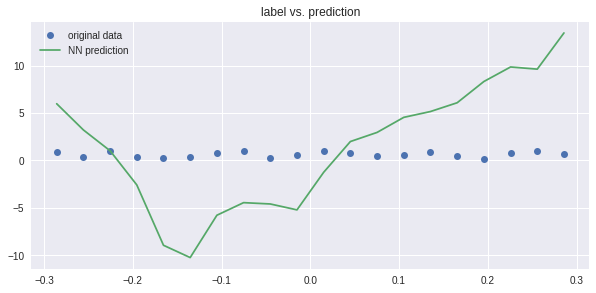



Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_nn_9 (SimpleNN)       multiple                  600       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


In [0]:
#@title Create NN model
nn_model = ComplexNN(num_inputs=1, num_units=200, activation='tanh')
nn_model(data_points)

plot_fig()
print('\n')
print("Model Summary")
nn_model.summary()

In [0]:
#@title Learning rate Schedule + Optimizer
learning_rate = 1e-3
global_step = tf.Variable(0)
learning_rate = tf.train.polynomial_decay(
    learning_rate, 
    global_step, 
    decay_steps=40000,
    end_learning_rate=1e-5, 
    cycle=False)
optimizer = tf.train.AdamOptimizer(learning_rate)
model = nn_model

Iter 074: Loss: 7.540651
Iter 149: Loss: 3.787560
Iter 224: Loss: 2.525094
Iter 299: Loss: 1.893831
Iter 374: Loss: 1.515067
Iter 449: Loss: 1.262556
Iter 524: Loss: 1.082191
Iter 599: Loss: 0.946917
Iter 674: Loss: 0.841704
Iter 749: Loss: 0.757534
Iter 824: Loss: 0.688667
Iter 899: Loss: 0.631278
Iter 974: Loss: 0.582718
Iter 1049: Loss: 0.541096
Iter 1124: Loss: 0.505023
Iter 1199: Loss: 0.473459
Iter 1274: Loss: 0.445608
Iter 1349: Loss: 0.420852
Iter 1424: Loss: 0.398702
Iter 1499: Loss: 0.378767
Plot in Iteration 1499


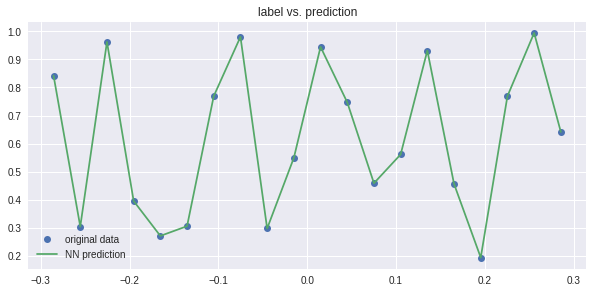

Iter 1574: Loss: 0.000000
Iter 1649: Loss: 0.000000
Iter 1724: Loss: 0.000000
Iter 1799: Loss: 0.000000
Iter 1874: Loss: 0.000000
Iter 1949: Loss: 0.000000
Iter 2024: Loss: 0.000000
Iter 2099: Loss: 0.000000
Iter 2174: Loss: 0.000000
Iter 2249: Loss: 0.000000
Iter 2324: Loss: 0.000000
Iter 2399: Loss: 0.000000
Iter 2474: Loss: 0.000000
Iter 2549: Loss: 0.000000
Iter 2624: Loss: 0.000000
Iter 2699: Loss: 0.000000
Iter 2774: Loss: 0.000000
Iter 2849: Loss: 0.000000
Iter 2924: Loss: 0.000000
Iter 2999: Loss: 0.000000
Plot in Iteration 2999


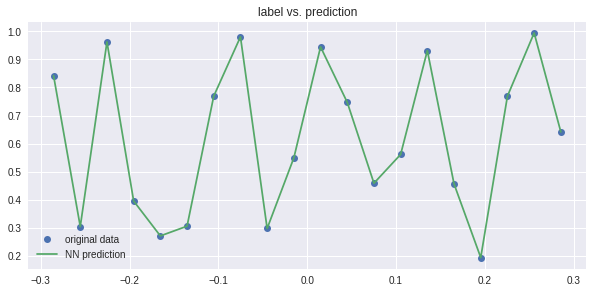

Iter 3074: Loss: 0.000000
Iter 3149: Loss: 0.000000
Iter 3224: Loss: 0.000000
Iter 3299: Loss: 0.000000
Iter 3374: Loss: 0.000000
Iter 3449: Loss: 0.000000
Iter 3524: Loss: 0.000000
Iter 3599: Loss: 0.000000
Iter 3674: Loss: 0.000000
Iter 3749: Loss: 0.000000
Iter 3824: Loss: 0.000000
Iter 3899: Loss: 0.000000
Iter 3974: Loss: 0.000000
Iter 4049: Loss: 0.000000
Iter 4124: Loss: 0.000000
Iter 4199: Loss: 0.000000
Iter 4274: Loss: 0.000000
Iter 4349: Loss: 0.000000
Iter 4424: Loss: 0.000000
Iter 4499: Loss: 0.000000
Plot in Iteration 4499


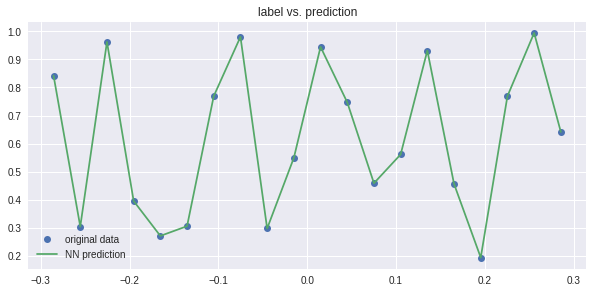

Iter 4574: Loss: 0.000000
Iter 4649: Loss: 0.000000
Iter 4724: Loss: 0.000000
Iter 4799: Loss: 0.000001
Iter 4874: Loss: 0.000001
Iter 4949: Loss: 0.000001
Iter 5024: Loss: 0.000002
Iter 5099: Loss: 0.000002
Iter 5174: Loss: 0.000002
Iter 5249: Loss: 0.000006
Iter 5324: Loss: 0.000005
Iter 5399: Loss: 0.000008
Iter 5474: Loss: 0.000009
Iter 5549: Loss: 0.000008
Iter 5624: Loss: 0.000012
Iter 5699: Loss: 0.000012
Iter 5774: Loss: 0.000011
Iter 5849: Loss: 0.000011
Iter 5924: Loss: 0.000015
Iter 5999: Loss: 0.000015
Plot in Iteration 5999


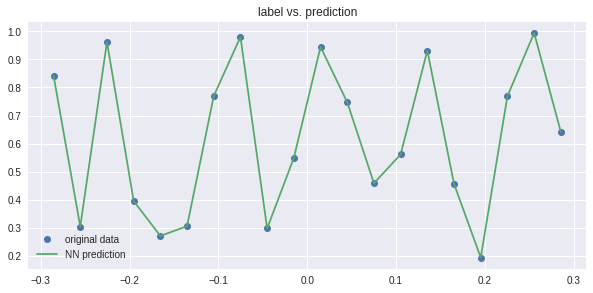

In [0]:
#@title Training

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_iters = 201 * 30
iteration = 0
num_iters_per_epoch = 75 * (NUM_DATAPOINTS // BATCH_SIZE)
epoch = 0

tfe = tf.contrib.eager
epoch_loss_avg = tfe.metrics.Mean()
# epoch_accuracy = tfe.metrics.Accuracy()
grad_fn = lambda x, y: grad(model, x, y, loss_fn=mse_loss)

# Training loop - using batches of 256
for x, y in ds_tensors:   
  # Optimize the model
  loss_value, grads = grad_fn(x, y)
  optimizer.apply_gradients(
      zip(grads, model.trainable_variables), global_step)

  # Track progress
  epoch_loss_avg(loss_value)  # add current batch loss
  # compare predicted label to actual label
  # epoch_accuracy(tf.cast(model(x) > 0, dtype=tf.int32),
  #               tf.cast(y > 0.5, dtype=tf.int32))
  
  if (iteration + 1) % num_iters_per_epoch == 0:
    train_loss_results.append(epoch_loss_avg.result())
    # train_accuracy_results.append(epoch_accuracy.result())

    print("Iter {:03d}: Loss: {:.6f}".format(
        iteration, epoch_loss_avg.result()))
          
  if (iteration + 1) % (num_iters_per_epoch * 20) == 0:
    print('Plot in Iteration {}'.format(iteration))
    plot_fig()

    # reset epoch counters
    epoch_loss_avg = tfe.metrics.Mean()
    # epoch_accuracy = tfe.metrics.Accuracy()

  iteration += 1
  if iteration > num_iters:
    break